In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
import numpy as np
import cv2 
import os


def dataset_setup(data_dir='', n_ims=2975, offset_bias=0, img_dim=256):
    """
    Method to import the training data from CityScape and divide into image-label pairs

    Inputs
    --
    data_dir: string
        Location for the data that is being imported
    n_ims: int
        Number of images contained in the folder chosen
    offset_bias: int
        Optionally, skip some images by starting at a position further than 0
    img_dim: int
        Expected image dimension (assuming square images)

    Outputs
    --
    X: list
        Images
    y: list
        Image labels per pixel
    """

    flist = os.listdir(data_dir)
    img0 = cv2.imread(data_dir+flist[0])

    y_dim,x_dim,_ = np.shape(img0)
    X = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    y = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    
    k = 0
    for f in flist[offset_bias:offset_bias+n_ims]:
        X[k] = cv2.imread(data_dir+f)[:,:img_dim]/img_dim
        y[k] = cv2.imread(data_dir+f)[:,img_dim:]/img_dim
        k = k+1

    return X, y

In [2]:
import matplotlib.pyplot as plt

# Directories containing the train and val data
train_files = "./ECE228_project/data/train/"
val_files = "./ECE228_project/data/val/"

# Setup image-label pairs
x_train, y_train = dataset_setup(data_dir=train_files, n_ims=2975, offset_bias=0, img_dim=256)
x_val, y_val = dataset_setup(data_dir=val_files, n_ims=500, offset_bias=0, img_dim=256)

In [3]:
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose, Conv2D, concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras import Model, Input


def conv2d_block(input_tensor, n_filters=16, filter_size=3, activation='relu', pad='same', batch_norm=True):
    """
    Custom block method to perform consecutive convolutions with optional batch normalization

    Inputs
    --
    input_tensor: tensor
        Input image tensor data structure defined within Keras
    n_filters: int
        Depth for the convolution layer outputs
    filter_size: int
        Dimensions of the filter convolved with the tensor inputs
    activation: string
        Activation function for the intermediate layers between convolutions
    pad: string
        Determination of if input shape is maintained in convolution
    batch_norm: bool
        Flag if batch normalization is used

    Outputs
    --
    x: tensor
        Twice convolved input with optional batch normalization and activation non-linearities
    """
    
    x = Conv2D(filters=n_filters, kernel_size=(filter_size, filter_size),
               kernel_initializer='he_normal', padding=pad)(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters=n_filters, kernel_size=(filter_size, filter_size),
               kernel_initializer='he_normal', padding=pad)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


def UNET(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=32, dropout=0.5, padding='same', batch_norm=True):
    """
    UNET architecture as originally outlined in https://arxiv.org/pdf/1505.04597.pdf with modifications 
    to fit different input dimensions. 

    Inputs
    --
    input_shape: tuple(int)
        Tuple in 3D corresponding to the dimensions of the input images
    conv_block: func
        Custom block method to perform consecutive convolutions with optional batch normalization
    n_filters: int
        Number of filters corresponding to depth of input for next layer
    dropout: float
        Dropout percentage hyperparameter to tune overfitting
    padding: string
        Descriptor determining if padding maintain size during convolutions
    batch_norm: bool
        Determines if batch normalization is used

    Outputs
    --
    model: Model
        Returns model architecture without compile
    """

    tensor = Input(shape=input_shape)

    print('Contracting Path')
    c1 = conv_block(tensor, n_filters * 1, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv_block(p1, n_filters * 2, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv_block(p2, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv_block(p3, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv_block(p4, n_filters * 16, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    print('Expanding Path')
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding=padding)(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv_block(u6, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding=padding)(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv_block(u7, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv_block(u8, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv_block(u9, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[tensor], outputs=[outputs])

    # Return model architecture
    return model

In [4]:
# Initialize UNET
model = UNET(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=32, dropout=0.5, padding='same', batch_norm=True)
print(model.summary())

Contracting Path
Expanding Path
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________

In [5]:
# Compile model with specified optimizer and loss
model.compile(optimizer='adam', loss='MSE')

In [6]:
# Track model history as it trains
import tensorflow as tf
print(tf.__version__)

h = model.fit(x_train, y_train, epochs=3, shuffle=True, batch_size=10, validation_data=(x_val, y_val))

2.1.0
Train on 2975 samples, validate on 500 samples
Epoch 1/3
2975/2975 [==============================] - 61s 20ms/sample - loss: 0.0307 - val_loss: 0.0359
Epoch 2/3
2975/2975 [==============================] - 51s 17ms/sample - loss: 0.0193 - val_loss: 0.0201
Epoch 3/3
2975/2975 [==============================] - 51s 17ms/sample - loss: 0.0168 - val_loss: 0.0176


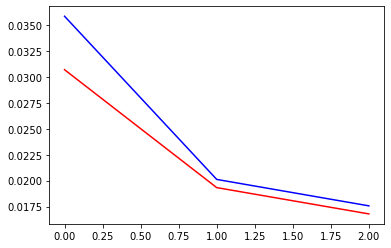

In [31]:
# Print results for training MSE and validation MSE
plt.plot(h.history['loss'], 'r')
ax1.set_aspect('equal')
ax1.set_axis_off()
ax1.set_title('tricontour')

plt.plot(h.history['val_loss'], 'b')
ax2.set_aspect('equal')
ax2.set_axis_off()
ax2.set_title('tricontour')
plt.show()

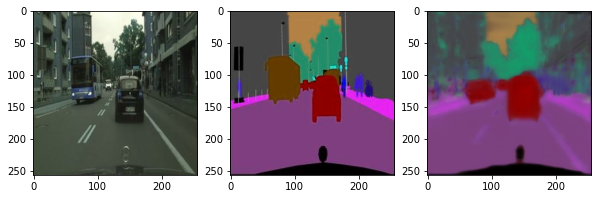

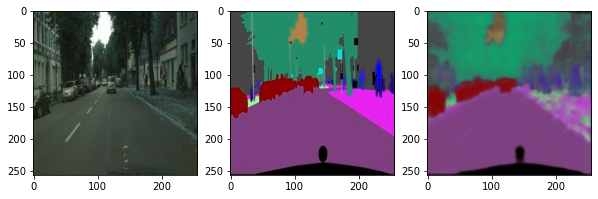

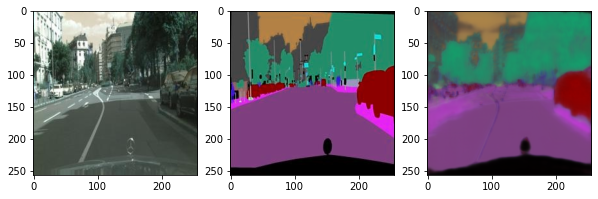

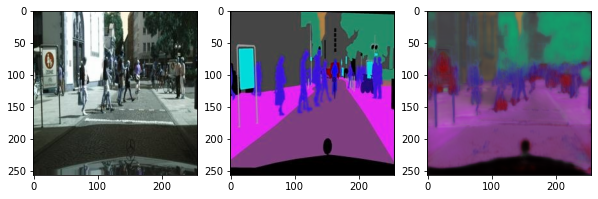

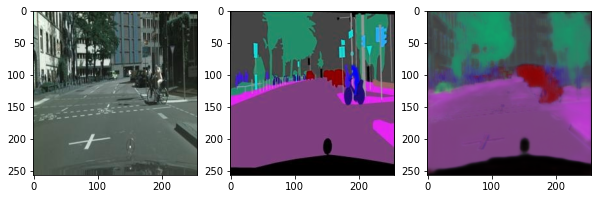

In [32]:
#show the result
pp = model.predict(x_val[0:5,:,:,:])

ni = 5
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pp[k])